In [1]:
!pip install emoji
!pip install transformers --upgrade
!pip install torch
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 11.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.12

In [2]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification, Trainer, TrainingArguments
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
import emoji
import tensorflow as tf

In [3]:
# loading the dataset
hateXplain_df = pd.read_csv('/content/hateXplain.csv.zip')

In [4]:
# function to check if a string contains any emoji
def contains_emoji(text):
    return any(char in emoji.EMOJI_DATA for char in str(text))

# keep only rows with at least one emoji in 'post_tokens'
hateXplain_df = hateXplain_df[hateXplain_df['post_tokens'].apply(contains_emoji)].reset_index(drop=True)

print("Filtered dataset shape (with emojis only):", hateXplain_df.shape)

Filtered dataset shape (with emojis only): (4485, 5)


In [5]:
hateXplain_df

,post_id,annotator_id,label,target,post_tokens
0,1179088797964763136_twitter,1,hatespeech,Asian,<user> i am bit confused coz chinese ppl can n...
1,1179088797964763136_twitter,4,offensive,Asian,<user> i am bit confused coz chinese ppl can n...
2,1179088797964763136_twitter,3,hatespeech,Asian,<user> i am bit confused coz chinese ppl can n...
3,1104904416430194688_twitter,4,offensive,Women,all of my exes were cute but they were hoes i ...
4,1104904416430194688_twitter,8,offensive,Women,all of my exes were cute but they were hoes i ...
...,...,...,...,...,...
4480,9633841_gab,224,normal,Women,what are the odds that there ll be more hostil...
4481,9633841_gab,199,normal,Women,what are the odds that there ll be more hostil...
4482,9989999_gab,217,offensive,"Men, Women, Other",if ur still on twitter tell carlton i said his...
4483,9989999_gab,199,offensive,NaN,if ur still on twitter tell carlton i said his...


In [6]:
hateXplain_df = hateXplain_df.dropna(subset = ['post_id', 'label', 'post_tokens'])
hateXplain_df.describe(include='all')

,post_id,annotator_id,label,target,post_tokens
count,4485,4485.000000,4485,2355,4485
unique,1495,NaN,3,169,1491
top,9989999_gab,NaN,normal,African,<user> i fucking hate you 😂
freq,3,NaN,2401,511,6
mean,NaN,109.406912,NaN,NaN,NaN
std,NaN,96.485644,NaN,NaN,NaN
min,NaN,1.000000,NaN,NaN,NaN
25%,NaN,9.000000,NaN,NaN,NaN
50%,NaN,70.000000,NaN,NaN,NaN
75%,NaN,209.000000,NaN,NaN,NaN


In [7]:
grouped_df = hateXplain_df.groupby('post_id')
label = grouped_df['label'].agg(lambda x:x.value_counts().index[0]).to_frame().reset_index()

In [8]:
hateXplain_df = pd.merge(left = hateXplain_df[['post_id', 'post_tokens']], right = label, on = 'post_id', how = 'inner').drop_duplicates(subset = ['post_id']).reset_index(drop=True)
hateXplain_df

,post_id,post_tokens,label
0,1179088797964763136_twitter,<user> i am bit confused coz chinese ppl can n...,hatespeech
1,1104904416430194688_twitter,all of my exes were cute but they were hoes i ...,offensive
2,1165747950733135872_twitter,she wanna meet carti that bitch is a barbie 🦋,normal
3,1170428282313068550_twitter,bitches be so fine and got the nerve to like n...,offensive
4,1178396130385645568_twitter,<user> no idea who these women are they get al...,normal
...,...,...,...
1490,833004295494762496_twitter,i need more gay friends 🏳 ️ ‍ 🌈,normal
1491,8533874_gab,fuck ramadan fuck moslems death 💀 be upon you ...,hatespeech
1492,8739790_gab,i should write a comic book about a white supe...,hatespeech
1493,9633841_gab,what are the odds that there ll be more hostil...,normal


### Pre-Processing Text

In [9]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [10]:
def preprocess_text(text):

    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize the text into words
    tokens = word_tokenize(text)

    # Remove stopwords (common words like "the", "is", etc.)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Join tokens back into a single string
    preprocessed_text = ' '.join(filtered_tokens)

    return preprocessed_text

def remove_numbers(text):
    # Remove all digits from the text
    text=''.join([i for i in text if not i.isdigit()])
    return text

In [11]:
hateXplain_df['post_tokens'] = hateXplain_df['post_tokens'].apply(preprocess_text)

In [12]:
hateXplain_df['post_tokens'] = hateXplain_df['post_tokens'].apply(remove_numbers)

In [13]:
hateXplain_df

,post_id,post_tokens,label
0,1179088797964763136_twitter,user bit confused coz chinese ppl access twitt...,hatespeech
1,1104904416430194688_twitter,exes cute hoes guess attract fly looking thots,offensive
2,1165747950733135872_twitter,wan na meet carti bitch barbie,normal
3,1170428282313068550_twitter,bitches fine got nerve like niggas,offensive
4,1178396130385645568_twitter,user idea women get credit jumping women calli...,normal
...,...,...,...
1490,833004295494762496_twitter,need gay friends,normal
1491,8533874_gab,fuck ramadan fuck moslems death upon filthy st...,hatespeech
1492,8739790_gab,write comic book white superhero takes woodchi...,hatespeech
1493,9633841_gab,odds hostility women politics emerge already q...,normal


### Pre-Processing Label

In [14]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
hateXplain_df['label_encoder'] = label_encoder.fit_transform(hateXplain_df['label'])

In [15]:
hateXplain_df

,post_id,post_tokens,label,label_encoder
0,1179088797964763136_twitter,user bit confused coz chinese ppl access twitt...,hatespeech,0
1,1104904416430194688_twitter,exes cute hoes guess attract fly looking thots,offensive,2
2,1165747950733135872_twitter,wan na meet carti bitch barbie,normal,1
3,1170428282313068550_twitter,bitches fine got nerve like niggas,offensive,2
4,1178396130385645568_twitter,user idea women get credit jumping women calli...,normal,1
...,...,...,...,...
1490,833004295494762496_twitter,need gay friends,normal,1
1491,8533874_gab,fuck ramadan fuck moslems death upon filthy st...,hatespeech,0
1492,8739790_gab,write comic book white superhero takes woodchi...,hatespeech,0
1493,9633841_gab,odds hostility women politics emerge already q...,normal,1


In [38]:
print(hateXplain_df['label_encoder'].value_counts())

label_encoder
1    824
2    422
0    249
Name: count, dtype: int64


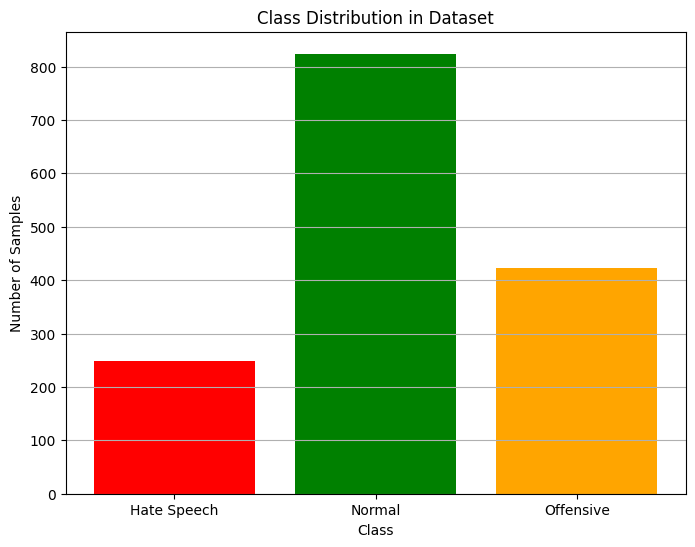

In [41]:
import matplotlib.pyplot as plt

# map numeric labels to readable class names
label_map = {0: 'Hate Speech', 1: 'Normal', 2: 'Offensive'}
counts = hateXplain_df['label_encoder'].value_counts().sort_index()
labels = [label_map[i] for i in counts.index]

# plotting
plt.figure(figsize=(8, 6))
plt.bar(labels, counts.values, color=['red', 'green', 'orange'])
plt.title('Class Distribution in Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.grid(axis='y')
plt.show()

### Pre-Processing Text for BertTokenizer

In [16]:
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
import torch.nn.functional as F

In [17]:
# function to replace emojis with their text description for the model that incorporates emoji in its sentiment analysis
def emoji2desc(text):
  return emoji.replace_emoji(text, replace=lambda chars, data_dict: ' '.join(data_dict['en'].split('_')).strip(':'))

# Text-only (control model)
posts_no_emojis = hateXplain_df['post_tokens']

# Text + emoji descriptions (emoji2desc model)
posts_with_emoji_desc = hateXplain_df['post_tokens'].apply(emoji2desc)

In [18]:
# load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# tokenize control (no emojis)
encoded_posts_no_emojis = tokenizer(posts_no_emojis.tolist(), padding=True, truncation=True, return_tensors='pt')

# tokenize text + emoji descriptions
encoded_posts_with_emoji_desc = tokenizer(posts_with_emoji_desc.tolist(), padding=True, truncation=True, return_tensors='pt')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [19]:
# getting input ids and attention masks for the model without emojis (using only the text)
input_ids_no_emojis = encoded_posts_no_emojis['input_ids']
attention_mask_no_emojis = encoded_posts_no_emojis['attention_mask']


# getting input ids and attention masks for the model with emojis (using both text and emoji description)
input_ids_with_emojis = encoded_posts_with_emoji_desc['input_ids']
attention_mask_with_emojis = encoded_posts_with_emoji_desc['attention_mask']

### Making Datasets and DataLoaders For Each Model

In [49]:
# Dataset for the model without emojis
class CyberBullyingDatasetWithoutEmojis(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

# Dataset for the model with emojis
class CyberBullyingDatasetWithEmojis(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

In [50]:
labels_tensor = torch.tensor(hateXplain_df['label_encoder'].values)

In [51]:
# DataLoader for the model without emojis
dataset_no_emojis = CyberBullyingDatasetWithoutEmojis(input_ids_no_emojis, attention_mask_no_emojis, labels_tensor)
dataloader_no_emojis = DataLoader(dataset_no_emojis, batch_size=32, shuffle=True)

# DataLoader for the model with emojis
dataset_with_emojis = CyberBullyingDatasetWithEmojis(input_ids_with_emojis, attention_mask_with_emojis, labels_tensor)
dataloader_with_emojis = DataLoader(dataset_with_emojis, batch_size=32, shuffle=True)

### Training the models

In [52]:
# Model for the text-only data (no emojis)
model_without_emojis = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_without_emojis.to(device)

# Model for the text + emoji sentiment data
model_with_emojis = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model_with_emojis.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [53]:
# For the text-only model (no emojis)
optimizer_no_emojis = AdamW(model_without_emojis.parameters(), lr=2e-5, eps=1e-8)

num_epochs = 15
total_steps_no_emojis = len(dataloader_no_emojis) * num_epochs

scheduler_no_emojis = get_linear_schedule_with_warmup(optimizer_no_emojis,
                                                      num_warmup_steps=0,
                                                      num_training_steps=total_steps_no_emojis)

# For the text + emoji model
optimizer_with_emojis = AdamW(model_with_emojis.parameters(), lr=2e-5, eps=1e-8)

total_steps_with_emojis = len(dataloader_with_emojis) * num_epochs

scheduler_with_emojis = get_linear_schedule_with_warmup(optimizer_with_emojis,
                                                        num_warmup_steps=0,
                                                        num_training_steps=total_steps_with_emojis)

### Training Loop for Text Only Model (Without Emojis)

In [54]:
# Initialize lists to store metrics
losses_no_emojis = []
accuracies_no_emojis = []

epochs = 10
for epoch in range(epochs):
    model_without_emojis.train()
    total_loss = 0
    correct_predictions = 0

    for batch in dataloader_no_emojis:
        optimizer_no_emojis.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # forward pass
        outputs = model_without_emojis(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # loss
        total_loss += loss.item()

        # backward + optimization
        loss.backward()
        optimizer_no_emojis.step()
        scheduler_no_emojis.step()

        # accuracy
        preds = torch.argmax(F.softmax(logits, dim=1), dim=1)
        correct_predictions += torch.sum(preds == labels)

    avg_loss = total_loss / len(dataloader_no_emojis)
    accuracy = correct_predictions.double() / len(dataloader_no_emojis.dataset)

    # Store for plotting
    losses_no_emojis.append(avg_loss)
    accuracies_no_emojis.append(accuracy.item())

    print(f"Epoch {epoch+1}, Loss: {avg_loss}, Accuracy: {accuracy}")


Epoch 1, Loss: 0.9778356006804932, Accuracy: 0.5484949832775919
Epoch 2, Loss: 0.8444447910532038, Accuracy: 0.6093645484949832
Epoch 3, Loss: 0.7318351027813363, Accuracy: 0.6936454849498327
Epoch 4, Loss: 0.5570035037842203, Accuracy: 0.7846153846153846
Epoch 5, Loss: 0.38478805853965437, Accuracy: 0.862876254180602
Epoch 6, Loss: 0.27365382396160287, Accuracy: 0.9096989966555183
Epoch 7, Loss: 0.19373711365017485, Accuracy: 0.9384615384615385
Epoch 8, Loss: 0.13686151953136666, Accuracy: 0.9618729096989966
Epoch 9, Loss: 0.1133131779571797, Accuracy: 0.9652173913043478
Epoch 10, Loss: 0.08802001225821515, Accuracy: 0.974581939799331


### Training Loop for the Text + Emoji Model

In [55]:
# initialize lists to store metrics
losses_with_emojis = []
accuracies_with_emojis = []

for epoch in range(epochs):
    model_with_emojis.train()
    total_loss = 0
    correct_predictions = 0

    for batch in dataloader_with_emojis:
        optimizer_with_emojis.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # forward pass
        outputs = model_with_emojis(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # loss
        total_loss += loss.item()

        # backward + optimization
        loss.backward()
        optimizer_with_emojis.step()
        scheduler_with_emojis.step()

        # accuracy
        preds = torch.argmax(F.softmax(logits, dim=1), dim=1)
        correct_predictions += torch.sum(preds == labels)

    avg_loss = total_loss / len(dataloader_with_emojis)
    accuracy = correct_predictions.double() / len(dataloader_with_emojis.dataset)

    # Store for plotting
    losses_with_emojis.append(avg_loss)
    accuracies_with_emojis.append(accuracy.item())

    print(f"Epoch {epoch+1}, Loss: {avg_loss}, Accuracy: {accuracy}")


Epoch 1, Loss: 0.9750597857414408, Accuracy: 0.5444816053511705
Epoch 2, Loss: 0.8189466456149487, Accuracy: 0.6528428093645484
Epoch 3, Loss: 0.6786008229915131, Accuracy: 0.7391304347826086
Epoch 4, Loss: 0.5121628971810036, Accuracy: 0.8120401337792642
Epoch 5, Loss: 0.3484238126176469, Accuracy: 0.8856187290969899
Epoch 6, Loss: 0.23252824884145817, Accuracy: 0.9311036789297659
Epoch 7, Loss: 0.16095035261613258, Accuracy: 0.9578595317725752
Epoch 8, Loss: 0.11270282171825145, Accuracy: 0.9698996655518394
Epoch 9, Loss: 0.08107651591776534, Accuracy: 0.9826086956521739
Epoch 10, Loss: 0.06259159490149072, Accuracy: 0.9846153846153846


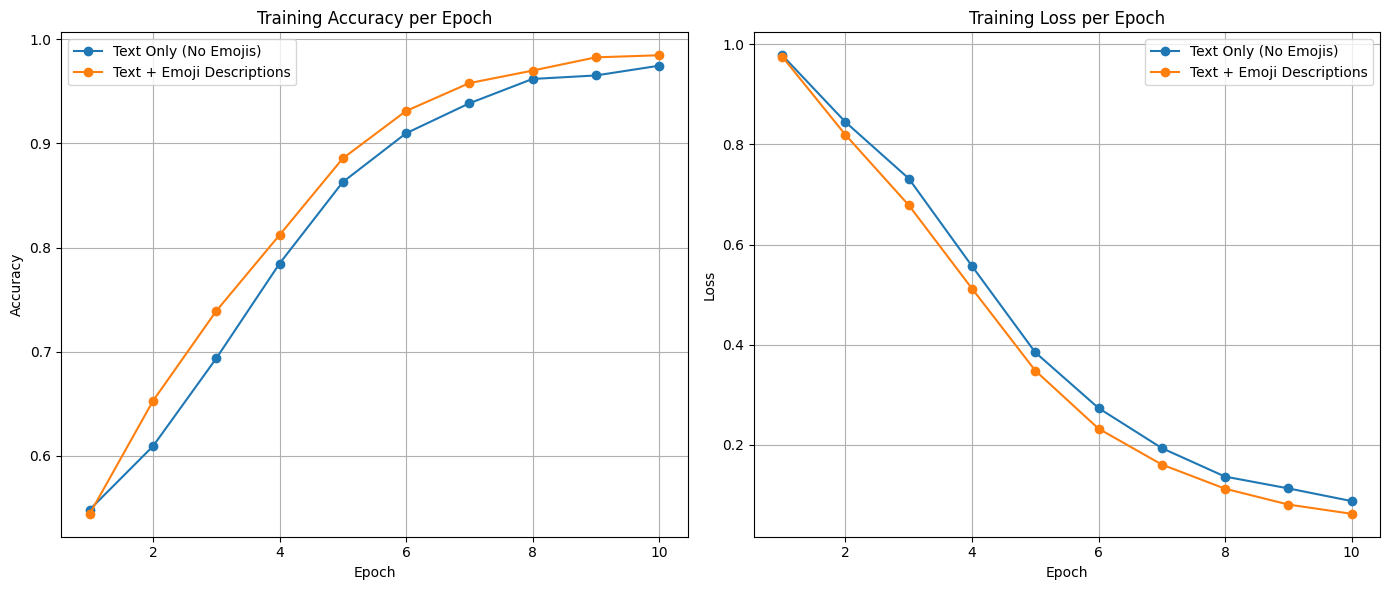

In [56]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(accuracies_no_emojis) + 1))

# Create the plot
plt.figure(figsize=(14, 6))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracies_no_emojis, label='Text Only (No Emojis)', marker='o')
plt.plot(epochs, accuracies_with_emojis, label='Text + Emoji Descriptions', marker='o')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(epochs, losses_no_emojis, label='Text Only (No Emojis)', marker='o')
plt.plot(epochs, losses_with_emojis, label='Text + Emoji Descriptions', marker='o')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Prediction Using BERT Model




In [64]:
final_hateXplain_df = pd.read_csv('/content/final_hateXplain.csv.zip')

In [65]:
# keep only rows with at least one emoji in 'post_tokens' in the test set
final_hateXplain_df = final_hateXplain_df[final_hateXplain_df['comment'].apply(contains_emoji)].reset_index(drop=True)

print("Filtered test dataset shape (with emojis only):", final_hateXplain_df.shape)

Filtered test dataset shape (with emojis only): (1491, 7)


In [66]:
final_hateXplain_df

,comment,label,Race,Religion,Gender,Sexual Orientation,Miscellaneous
0,0 u0 lmao wow fuck you too 😂 😂,normal,No_race,Nonreligious,No_gender,No_orientation,NaN
1,1 2 h ago ching chong accepted your friend req...,offensive,Asian,Nonreligious,No_gender,No_orientation,NaN
2,1 8 th century mayhem and lawlessness had noth...,normal,No_race,Nonreligious,No_gender,No_orientation,NaN
3,<number> i hope they are not blaming the raghe...,hatespeech,Arab,Nonreligious,Women,No_orientation,NaN
4,<number> mosques in the uk preaching hate to i...,hatespeech,Indian,Islam,No_gender,No_orientation,NaN
...,...,...,...,...,...,...,...
1486,😂 😂 😂 😂 😂 y ’ all be so mad at caucasians fail...,offensive,African,Nonreligious,No_gender,No_orientation,NaN
1487,🤔 🤔 🤔 🤔 mmm yes the trebuchet memes are much n...,hatespeech,Arab,Islam,No_gender,No_orientation,NaN
1488,🤣 this so ghetto i ’ m ready to get tf,offensive,No_race,Nonreligious,No_gender,No_orientation,Other
1489,🤣 🤣 😂 😂 🤣 🤣 😂 😂 🤣 🤣 you spelled my name wrong ...,hatespeech,Arab,Nonreligious,No_gender,No_orientation,NaN


### Pre-Processing Text

In [67]:
final_hateXplain_df['comment'] = final_hateXplain_df['comment'].apply(preprocess_text)
final_hateXplain_df['comment'] = final_hateXplain_df['comment'].apply(remove_numbers)

### Pre-Processing Label

In [68]:
final_hateXplain_df['label_encoder'] = label_encoder.fit_transform(final_hateXplain_df['label'])

In [79]:
# Extract comments from the dataframe
test_comments = final_hateXplain_df['comment'].tolist()

test_encodings = tokenizer(test_comments, padding=True, truncation=True, return_tensors='pt')

test_labels = torch.tensor(final_hateXplain_df['label_encoder'].values)

In [81]:
# DataLoader for the model without emojis
test_dataset_no_emojis = CyberBullyingDatasetWithoutEmojis(input_ids, attention_mask, labels_tensor)
test_dataloader_no_emojis = DataLoader(dataset_no_emojis, batch_size=32, shuffle=True)

# DataLoader for the model with emojis
test_dataset_with_emojis = CyberBullyingDatasetWithEmojis(input_ids, attention_mask, labels_tensor)
test_dataloader_with_emojis = DataLoader(dataset_with_emojis, batch_size=32, shuffle=True)

In [82]:
# Set model to evaluation mode for the model without emojis
model_without_emojis.eval()
predictions_no_emojis = []
true_labels_no_emojis = []

with torch.no_grad():  # Disable gradient calculation for inference
    for batch in test_dataloader_no_emojis:  # Loop through test data for model without emojis
        input_ids = batch['input_ids'].to(device)  # Move input IDs to device
        attention_mask = batch['attention_mask'].to(device)  # Move attention mask to device
        labels = batch['labels'].to(device)  # Move labels to device

        # Perform forward pass for model without emojis
        outputs = model_without_emojis(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # Get model predictions (logits)

        # Get predicted class labels
        preds = torch.argmax(logits, dim=1)
        predictions_no_emojis.extend(preds.cpu().numpy())  # Store predictions
        true_labels_no_emojis.extend(labels.cpu().numpy())  # Store true labels

# After this, you can calculate accuracy for the model without emojis
from sklearn.metrics import accuracy_score
accuracy_no_emojis = accuracy_score(true_labels_no_emojis, predictions_no_emojis)
print(f"Accuracy for model without emojis: {accuracy_no_emojis:.4f}")

Accuracy for model without emojis: 0.9926


In [83]:
# Set model to evaluation mode for the model with emojis
model_with_emojis.eval()
predictions_with_emojis = []
true_labels_with_emojis = []

with torch.no_grad():  # Disable gradient calculation for inference
    for batch in test_dataloader_with_emojis:  # Loop through test data for model with emojis
        input_ids = batch['input_ids'].to(device)  # Move input IDs to device
        attention_mask = batch['attention_mask'].to(device)  # Move attention mask to device
        labels = batch['labels'].to(device)  # Move labels to device

        # Perform forward pass for model with emojis
        outputs = model_with_emojis(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # Get model predictions (logits)

        # Get predicted class labels
        preds = torch.argmax(logits, dim=1)
        predictions_with_emojis.extend(preds.cpu().numpy())  # Store predictions
        true_labels_with_emojis.extend(labels.cpu().numpy())  # Store true labels

# After this, you can calculate accuracy for the model with emojis
accuracy_with_emojis = accuracy_score(true_labels_with_emojis, predictions_with_emojis)
print(f"Accuracy for model with emojis: {accuracy_with_emojis:.4f}")

Accuracy for model with emojis: 0.9926


### Saving Both BERT Models

In [ ]:
# For the model without emojis
model_save_path_no_emojis = '/content/bert_model_no_emojis.pth'
torch.save(model_without_emojis.state_dict(), model_save_path_no_emojis)
print(f"Model without emojis saved to {model_save_path_no_emojis}")

# For the model with emojis
model_save_path_with_emojis = '/content/bert_model_with_emojis.pth'
torch.save(model_with_emojis.state_dict(), model_save_path_with_emojis)
print(f"Model with emojis saved to {model_save_path_with_emojis}")

Model without emojis saved to /content/bert_model_no_emojis.pth
Model with emojis saved to /content/bert_model_with_emojis.pth
